In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import jaccard_similarity_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from math import pi

from src.pre_processing import *

In [5]:
subset = create_subset(public_df, cols_to_keep)

In [29]:
pd.set_option('display.max_columns', 999)

In [24]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7426 entries, 0 to 7425
Data columns (total 40 columns):
responseLagSeconds             7426 non-null float64
dailyAlertNumber               6696 non-null float64
tiredness                      6388 non-null float64
feelingEmotion                 7426 non-null int64
generalEmotion                 7426 non-null object
specificEmotion                7426 non-null object
intensity                      7426 non-null float64
generalTrigger                 7426 non-null object
specificTrigger                7426 non-null object
bodySensationIntensity         7426 non-null float64
bodySensationForehead          7426 non-null int64
bodySensationEyes              7426 non-null int64
bodySensationJaw               7426 non-null int64
bodySensationNeck              7426 non-null int64
bodySensationShoulders         7426 non-null int64
bodySensationChest             7426 non-null int64
bodySensationArms              7426 non-null int64
bodySensatio

In [20]:
# fill with mode b/c of outliers (7.0 mode vs 7101 mean)
subset['responseLagSeconds'] = subset['responseLagSeconds'].fillna(subset['responseLagSeconds'].mode()[0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
# fill with 0's because we're dummifying trigger data anyways; and 0 is mode of workPilingUp

subset[['generalTrigger', 'specificTrigger', 'workPilingUp']] = subset[['generalTrigger', 'specificTrigger', 'workPilingUp']].fillna(0)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [25]:
# fill remaining null's with mean (dailyAlertNumber and tiredness) - they are close to the mode.

subset.fillna(subset.mean(), inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Dummify Categoricals

In [30]:
subset.head()

,responseLagSeconds,dailyAlertNumber,tiredness,feelingEmotion,generalEmotion,specificEmotion,intensity,generalTrigger,specificTrigger,bodySensationIntensity,bodySensationForehead,bodySensationEyes,bodySensationJaw,bodySensationNeck,bodySensationShoulders,bodySensationChest,bodySensationArms,bodySensationHands,bodySensationStomach,bodySensationBowel,bodySensationLegs,bodySensationFeet,bodySensationLowerBack,bodySensationUpperBack,bodySensationOther,bodySensationOtherLocation,emotionDuration,selfCareEatingWell,selfCareCooking,selfCareExercise,selfCareSeekingSupport,selfCareTimeOutside,selfCareSpiritualPractice,selfCareQualityTimeTogether,selfCareQualityTimeAlone,selfCarePet,selfCareOther,selfCareNone,selfCareOtherActivity,workPilingUp
0,2044.0,2.0,0.500000,1,enjoyment,peaceful,0.50,wellbeing,exercise,0.75,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,7642.0,2.0,0.465404,1,fear,anxious,0.25,workStress,workload,0.50,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,1330.0,4.0,0.465404,1,anger,frustrated,0.25,socialStress,soChallenge,0.25,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,73.0,1.0,0.465404,1,enjoyment,happy,0.50,socialSupport,timeFamily,0.50,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,56.0,2.0,0.465404,1,enjoyment,happy,0.50,wellbeing,play,0.50,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [31]:
for col in cols_to_dummify:
    dummify_clustering(subset, col)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
subset.head()

,responseLagSeconds,dailyAlertNumber,tiredness,feelingEmotion,intensity,bodySensationIntensity,bodySensationForehead,bodySensationEyes,bodySensationJaw,bodySensationNeck,bodySensationShoulders,bodySensationChest,bodySensationArms,bodySensationHands,bodySensationStomach,bodySensationBowel,bodySensationLegs,bodySensationFeet,bodySensationLowerBack,bodySensationUpperBack,bodySensationOther,bodySensationOtherLocation,emotionDuration,selfCareEatingWell,selfCareCooking,selfCareExercise,selfCareSeekingSupport,selfCareTimeOutside,selfCareSpiritualPractice,selfCareQualityTimeTogether,selfCareQualityTimeAlone,selfCarePet,selfCareOther,selfCareNone,selfCareOtherActivity,workPilingUp,anger,enjoyment,fear,other,sadness,afraid,angry,annoyed,anxious,ashamed,discouraged,embarrassed,enthusiastic,excited,frustrated,happy,irritated,joyful,lonely,nervous,notListed,peaceful,sad,worried,0,personalConcerns,socialStress,socialSupport,wellbeing,workSatisfaction,workStress,world,bodyImage,clientChallenge,clientEnjoyable,climateChange,colleagueChallenge,colleagueEnjoyable,dislikeJob,domesticPolitics,exercise,familyChallenge,financialStress,friendsChallenge,globalPolitics,healthProblems,healthcare,lackMotivation,paperwork,patientChallenge,patientEnjoyable,play,productivity,relaxation,sleepDeprived,soChallenge,spiritual,success,timeFamily,timeFriends,timeSO,workload
0,2044.0,2.0,0.500000,1,0.50,0.75,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7642.0,2.0,0.465404,1,0.25,0.50,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1330.0,4.0,0.465404,1,0.25,0.25,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,73.0,1.0,0.465404,1,0.50,0.50,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,56.0,2.0,0.465404,1,0.50,0.50,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Scale and NMF

In [34]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(subset)
scaled_subset = scaler.transform(subset)
scaled_subset

array([[0.18360191, 0.25      , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.18409864, 0.25      , 0.46540388, ..., 0.        , 0.        ,
        1.        ],
       [0.18353855, 0.75      , 0.46540388, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.18449164, 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.75      , 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.18342116, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
nmf = NMF(n_components=10, max_iter=50, random_state=12345, alpha=0.0)
W = nmf.fit_transform(scaled_subset)
H = nmf.components_
print ('reconstruction error:', nmf.reconstruction_err_)

reconstruction error: 129.25963856038163


In [54]:
error = []

for i in range (1, 36):
    nmf = NMF(n_components=i, max_iter=100, random_state=12345, alpha=0.0)
    W = nmf.fit_transform(scaled_subset)
    H = nmf.components_
    error.append(nmf.reconstruction_err_)
    

In [55]:
y = np.arange(1,36)

In [49]:
y

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [57]:
error

[177.47027583810362,
 164.78269758174758,
 158.76902521148318,
 153.07487761615246,
 148.5483802580076,
 143.78376286398708,
 140.09246211169855,
 136.47599281198902,
 132.3156535312,
 129.25960153988254,
 126.59725016462862,
 123.84864999915513,
 121.23599160115859,
 118.66629312802897,
 116.29279060215065,
 114.0664768157725,
 111.81447805877926,
 107.65602434489455,
 105.93260477548903,
 103.63984434865793,
 102.26512851321282,
 98.93550706493549,
 96.88295919223337,
 94.62702765261474,
 92.7439866207266,
 90.8778645447881,
 88.41934986560193,
 88.13264583718161,
 84.50337995756651,
 82.69968171910116,
 80.6409027071644,
 80.5863695487093,
 79.30008942705379,
 75.54154967538594,
 75.43348384116592]

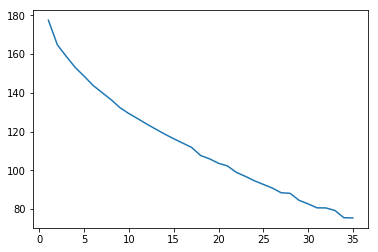

In [56]:
plt.plot(y, error)

In [58]:
nmf = NMF(n_components=34, max_iter=100, random_state=12345, alpha=0.0)
W = nmf.fit_transform(scaled_subset)
H = nmf.components_
print ('reconstruction error:', nmf.reconstruction_err_)

reconstruction error: 75.54154967538594


In [75]:
scaled_subset.shape

(7426, 98)

In [79]:
H.shape

(34, 98)

### kMeans after NMF

In [65]:
kmeans = KMeans(n_clusters=6)
predictions = kmeans.fit_predict(W)
predictions

array([5, 0, 0, ..., 2, 2, 3], dtype=int32)

In [66]:
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 403,  714, 3932,  441,  648, 1288]))

In [77]:
silhouette_score(W, predictions, metric='euclidean')

0.12682300088032536

In [73]:
X = W
range_n_clusters = range(2,10)

# taken from sklearn
def plot_silhouette(df):
    
    for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
        fig, (ax1) = plt.subplots(1)
        fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
        ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
        silhouette_avg = silhouette_score(X, cluster_labels, metric='euclidean')
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.07860379150820877


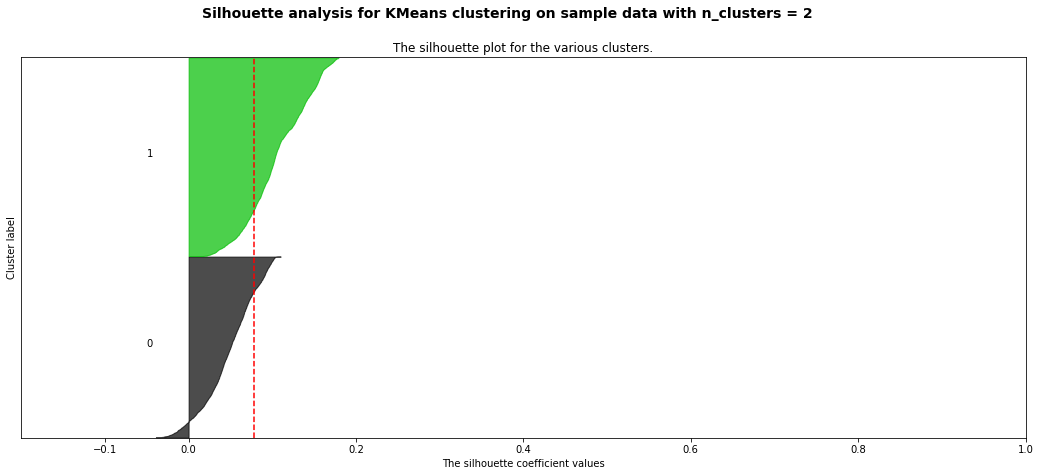

For n_clusters = 3 The average silhouette_score is : 0.0664511946278484


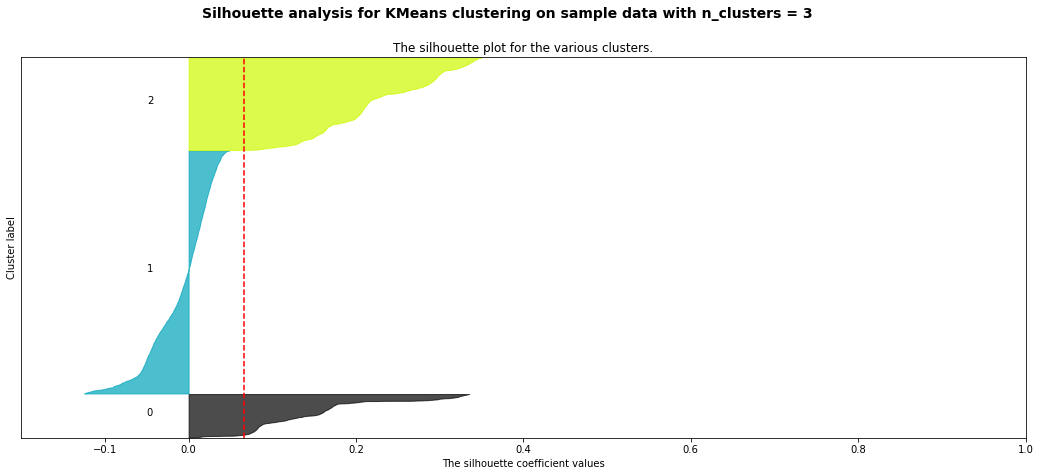

For n_clusters = 4 The average silhouette_score is : 0.10570625494175086


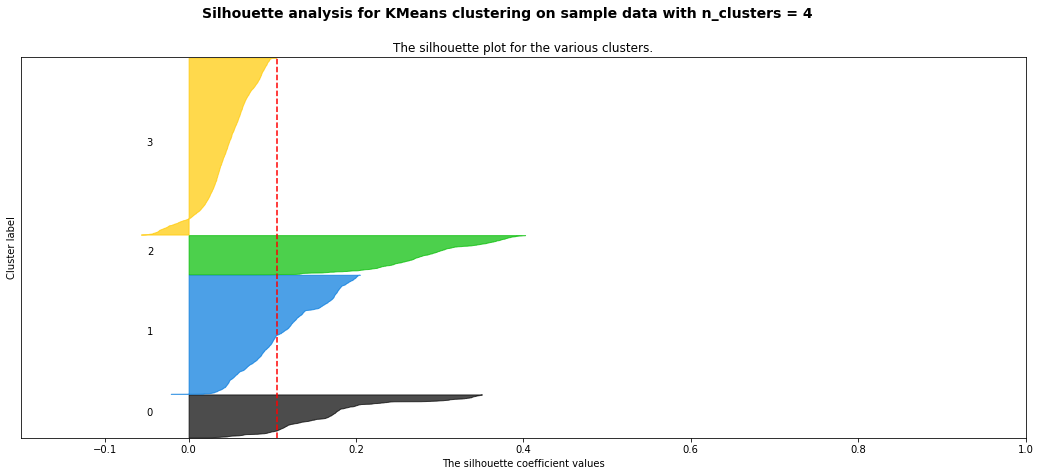

For n_clusters = 5 The average silhouette_score is : 0.11512536000045263


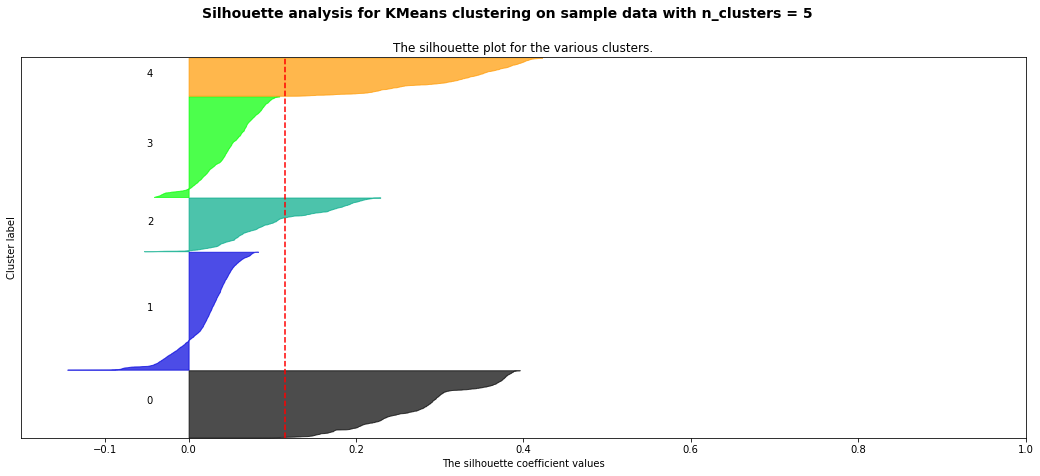

For n_clusters = 6 The average silhouette_score is : 0.13625301268360654


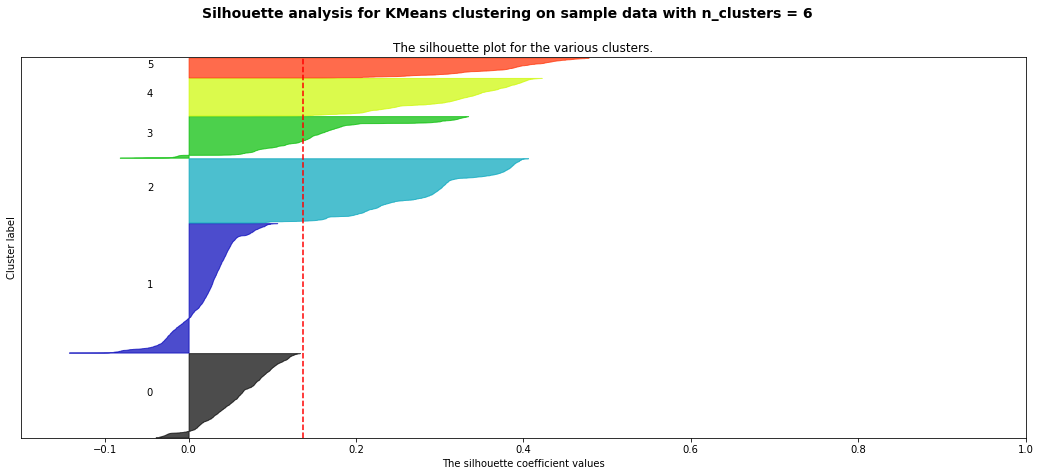

For n_clusters = 7 The average silhouette_score is : 0.15311483237128737


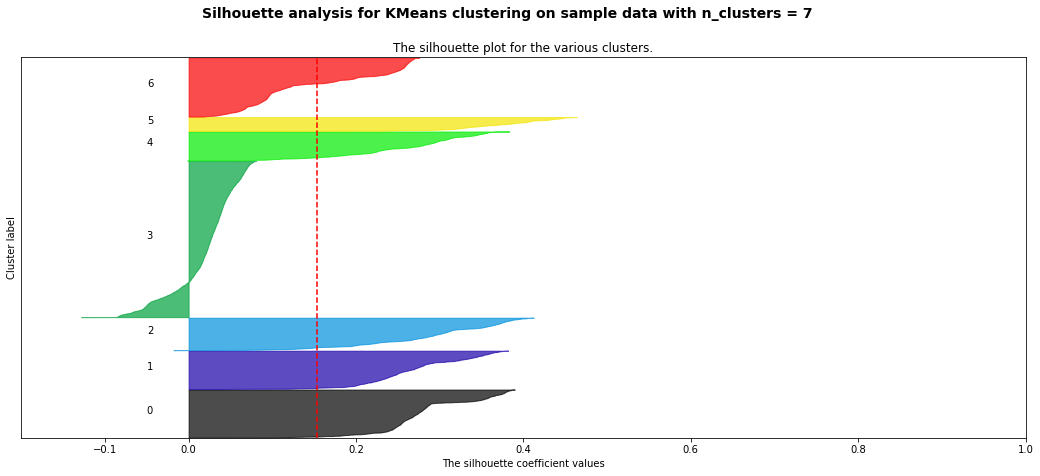

For n_clusters = 8 The average silhouette_score is : 0.1635851400631664


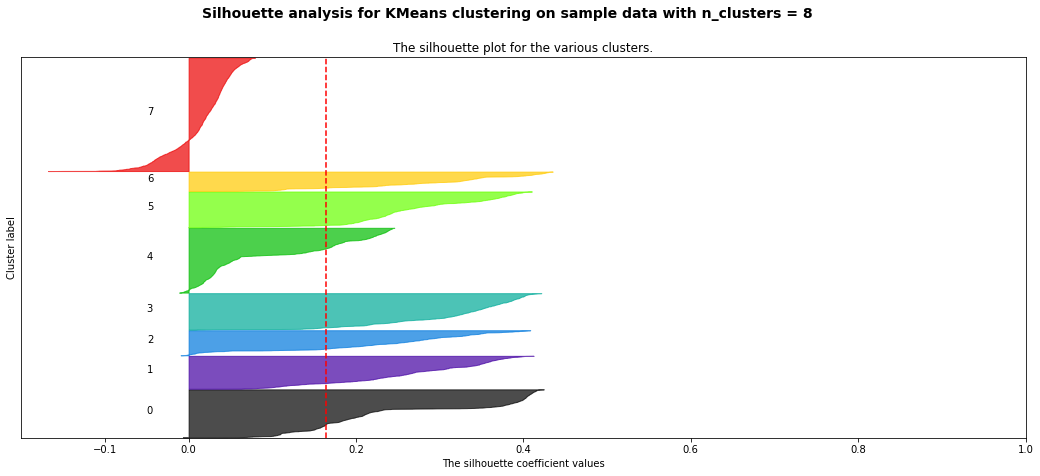

For n_clusters = 9 The average silhouette_score is : 0.1983005527674859


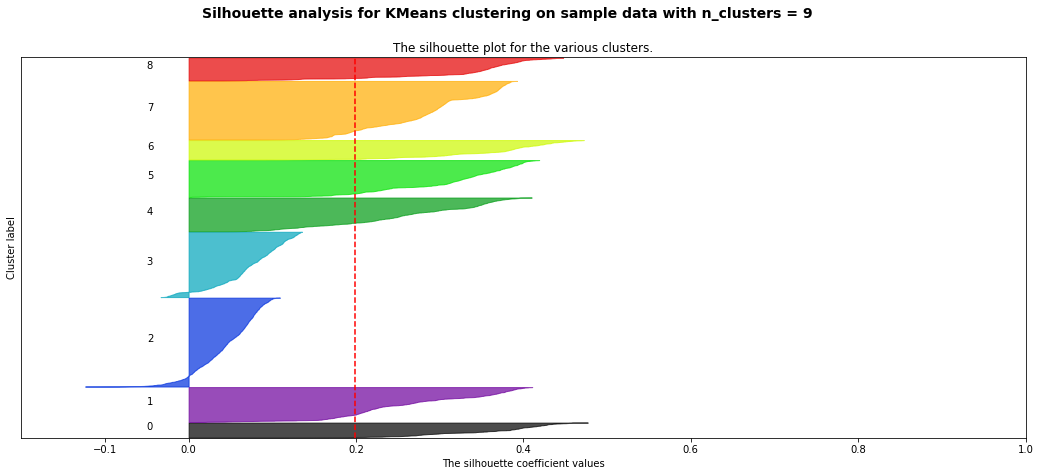

In [74]:
plot_silhouette(X)